In [458]:
%matplotlib inline
from itertools import product

from PIL import Image
from scipy import ndimage, signal
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
import numba
from skimage.filters import threshold_otsu
from skimage import io, color
import skimage.filters as fil

In [515]:
img = Image.open('../../data/processed//messidor/20060412_61365_0200_PP.tif')
img = Image.open('../../data/raw/DRIVE/training/images/36_training.tif')
#img = Image.open('../../data/processed/eyepacs/10100_right.jpeg')
#img.thumbnail([1024, 1024])
#img.thumbnail([512, 512])

#Y, _, _ = img.convert('YCbCr').split()
# , Y, _ = img.split()
Y = color.rgb2gray(np.array(img))

arr = np.array(Y, dtype=np.float)

arr = np.float32(Y)
black = threshold_otsu(arr)
black = arr < black

[]
-100000000000.0 1.67321234507


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 664 but corresponding boolean dimension is 584


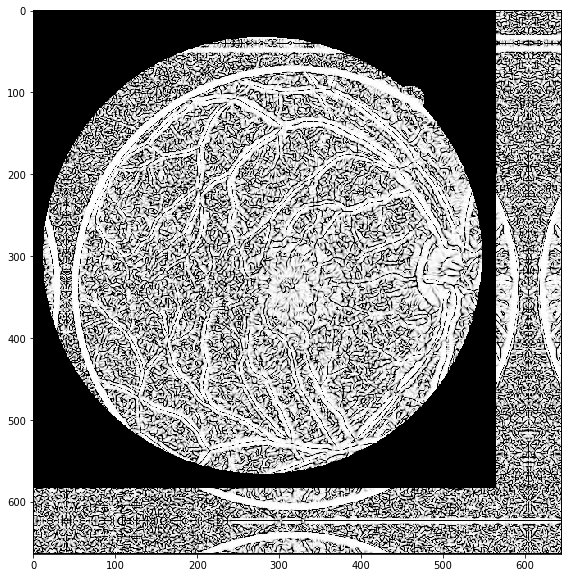

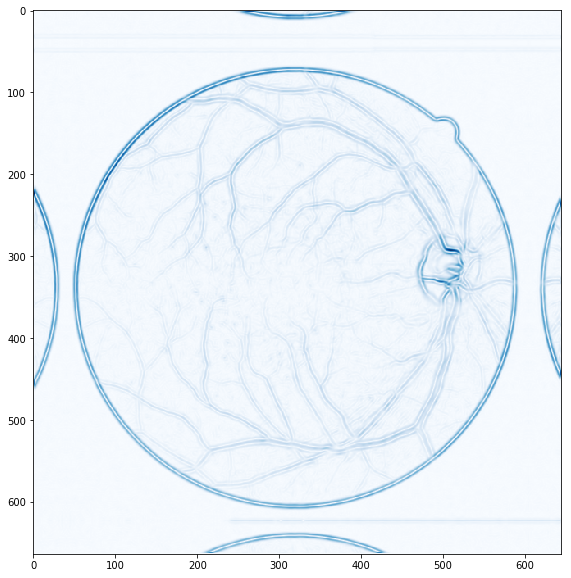

In [534]:
arr = np.float32(Y)/255.0
arr = fil.gaussian(arr, sigma=1.5)

pad_width = 40
arr = np.pad(arr, pad_width=pad_width, mode='reflect')

#img_dx, img_dy = np.gradient(arr)
#img_dxx, img_dxy = np.gradient(img_dx)
#_, img_dyy = np.gradient(img_dy)

img_dx = fil.scharr_h(arr)
img_dy = fil.scharr_v(arr)
img_dxx = fil.scharr_h(img_dx)
img_dyy = fil.scharr_v(img_dy)
img_dxy = fil.scharr_v(img_dx)

curvedness = np.sqrt(img_dxx**2 + 2* img_dxy**2 + img_dyy**2)
#curvedness[black] = .0

fig, ax = plt.subplots(figsize=(10,10))

img_dvv = img_dy**2 * img_dxx - 2 * img_dx * img_dxy * img_dy + img_dx**2 * img_dyy
img_dw = img_dx**2 + img_dy**2
curvature = -1 * img_dvv / (img_dw**(3./2))
print(curvature[np.isinf(curvature)])
curvature[np.isnan(curvature)] = -10e10 # todo
curvature[black] = -10e10

lo, hi = np.percentile(curvature, q=[5, 95])
print(lo,hi)
ax.imshow(np.abs(curvature).clip(lo,hi), cmap=cm.Greys)

#curvedness = (curvedness - curvedness.min())/curvedness.max()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow((curvedness), cmap=cm.Blues)



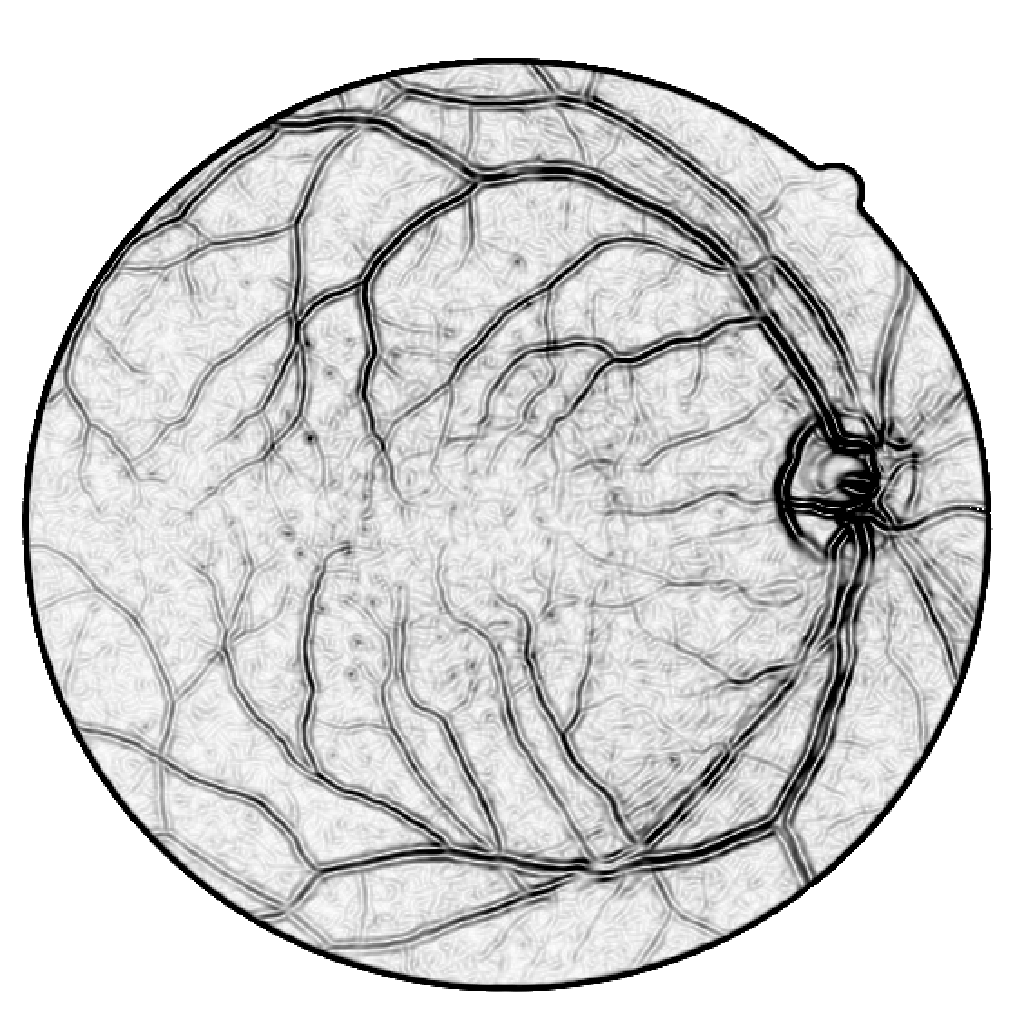

In [535]:
c = curvedness[pad_width:-pad_width, pad_width:-pad_width].copy()
not_important = ~np.array([c > np.percentile(curvedness, q=[40])[0]]).reshape(c.shape)
c[np.logical_and(black, not_important)] = 0
c[black] = 0
hi = np.percentile(curvedness, q=[95.5])[0]
c = c.clip(0.0, hi)
c = c/c.max()
Image.fromarray((1-c)*255.0).convert('RGB').resize((1024,1024))

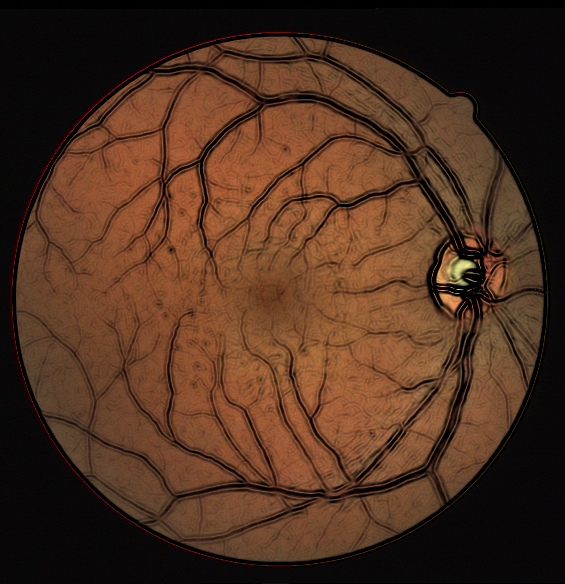

In [536]:
ImageChops.multiply(img, Image.fromarray((1-c)*255.0).convert('RGB'))
#img
#c.mean()
#black.shape, not_important.shape, c.shape

In [500]:
np.percentile(curvedness, q=[75])[0]

3.4953751028485308e-05

[ 0.          0.12150103  0.24300206  0.36450309  0.48600411  0.60750514
  0.72900617  0.8505072   0.97200823]


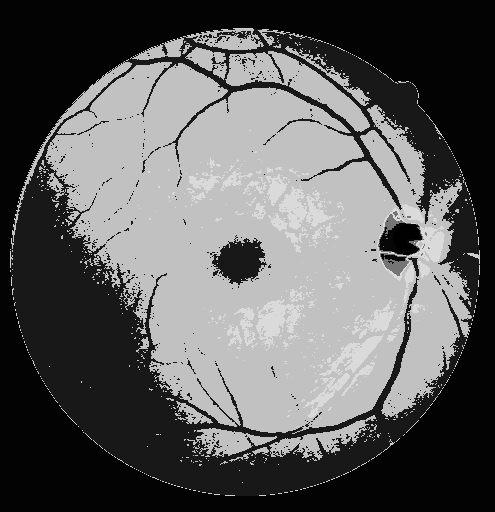

In [490]:
# TODO: Use better bins
num_bins = 6
hist, edges = np.histogram(np.float32(Y), bins=8)
probabilities = hist/hist.sum()
print(edges)

old_shape = np.float32(Y).shape
bins = (np.digitize(np.float32(Y).flatten(), edges) - 1)
probs = np.apply_over_axes(lambda a, _: probabilities[a -1], bins, 0)
probs = probs.reshape(old_shape)
probs = -np.log(probs)# * probs
probs = (probs/probs.max())# * (curvedness)
p = Image.fromarray((1-probs )*255.0).convert('RGB')
#ImageChops.multiply(img, p)
p

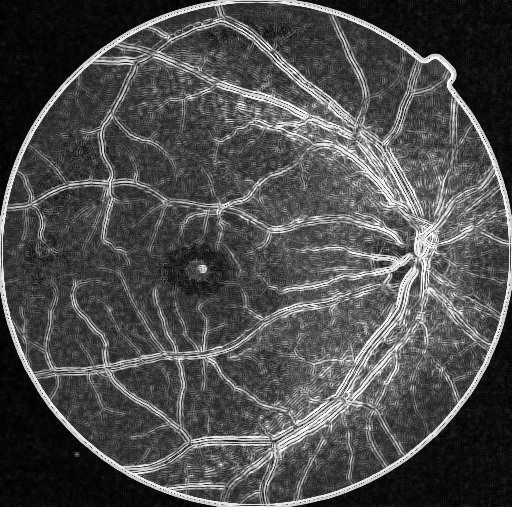

In [352]:
w = 0.8
Image.fromarray((w*c + (1-w)*(1-probs))*255.0).convert('RGB')

In [218]:
#pad_width = 10
#arr = np.pad(arr, pad_width=pad_width, mode='reflect')

#@numba.jit(nopython=True, parallel=True)
def entropy(arr, probabilities, bins):
    # Exclude center from array!
    #idx = np.ones(49, bool)
    idx = np.array([True]*49)
    idx[49//2] = True
    
    entr = np.zeros_like(arr, dtype=np.float)
    for i in numba.prange(arr.shape[0]):
        for j in range(arr.shape[1]):
            img_window = arr[i-3:i+1+3, j-3:j+1+3].flatten()

            # Boundary condition
            if len(img_window) < 49:
                entr[i][j] = 0
                continue

            hist = np.digitize(img_window, bins, right=True) - 1
            uniq, counts = np.unique(hist, return_counts=True)
            probs = np.zeros(num_bins)
            probs[uniq] = counts/counts.sum()
            p = probs[hist]
            assert(np.all((p >= 0.0) & (p <= 1.0)))
            log_p = np.log(p)
            
            entr[i][j] = -1 * (log_p * p).sum()
            
    return entr/np.max(entr)

entr = entropy(np.float32(Y), probabilities, edges)
entr = ndimage.gaussian_filter(entr, 0.5, truncate=3)

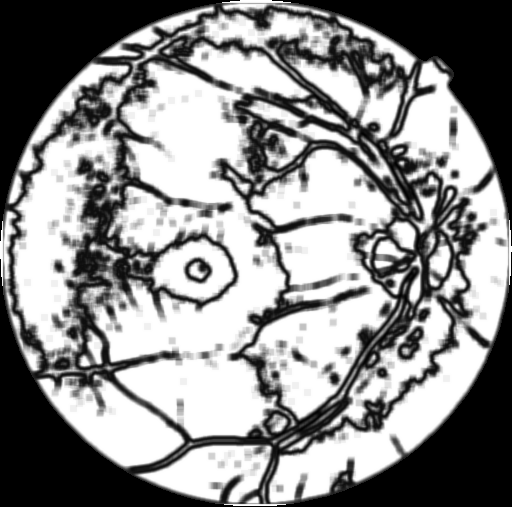

In [219]:
entr[black] = 1
Image.fromarray((1-entr)*255).convert('RGB')

In [220]:
c = 0.1*(uniq) + 0.9*(1-curvedness)
e = Image.fromarray(c*255).convert('RGB')
ImageChops.multiply(e, img)

NameError: name 'uniq' is not defined

In [221]:
@numba.jit(nopython=True, parallel=True)
def get_neighbour_distance(size_sqrt=7):
    assert(size_sqrt % 2 == 1)
    size = size_sqrt**2
    d = np.zeros(size).reshape(size_sqrt, size_sqrt)
    center = size_sqrt//2
    #d[center][center] = 0.0 # center
    for i in range(center+1):
        for j in range(center+1):
            d[center+i][center+j] = (i**2 + j**2)**0.5
            d[center+i][center-j] = (i**2 + j**2)**0.5
            d[center-i][center+j] = (i**2 + j**2)**0.5
            d[center-i][center-j] = (i**2 + j**2)**0.5
    #d = np.zeros(size).reshape(size_sqrt, size_sqrt)
    #d[center][center] = 1.0
    d = np.exp(-d)
    return d

#@numba.jit(nopython=True, parallel=True)
def uniqueness(arr, feature_map):
    # Pad
    #pad_width = 10
    #feature_map = np.pad(feature_map, pad_width=pad_width, mode='median') # Maybe reflect?
    #feature_map = feature_map.astype(float)
    
    res = np.zeros_like(feature_map, dtype=np.float32)
    
    window_size_sqrt = 7
    window_size = window_size_sqrt**2
    center = window_size//2
    size = window_size_sqrt//2
    
    img_window = get_neighbour_distance(window_size_sqrt).flatten()
    print(img_window)

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            #img_window = arr[i-size:i+size+1, j-size:j+size+1].flatten()# /arr.max()
            feature_window = feature_map[i-size:i+size+1, j-size:j+size+1].flatten()
            
            # Taken care of by padding!
            if len(feature_window) < window_size or len(img_window) < window_size:
                continue
                
            assert(feature_window.shape == img_window.shape)
                                
            # All neighbours exist
            #img_center = img_window[center]
            feature_center = feature_window[center]
            
            feature_dist = np.abs(feature_center - feature_window)# * 0 + 1
            
            res[i][j] = (img_window @ feature_dist)
        
    # Remove padding
    #res = res[pad_width:-pad_width, pad_width:-pad_width]
    return res/res.max()
            
uniq = uniqueness(arr, 1-entr)

[ 0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696   0.02717246  0.05910575  0.10687793  0.13533528  0.10687793
  0.05910575  0.02717246  0.04232922  0.10687793  0.24311673  0.36787944
  0.24311673  0.10687793  0.04232922  0.04978707  0.13533528  0.36787944
  1.          0.36787944  0.13533528  0.04978707  0.04232922  0.10687793
  0.24311673  0.36787944  0.24311673  0.10687793  0.04232922  0.02717246
  0.05910575  0.10687793  0.13533528  0.10687793  0.05910575  0.02717246
  0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696 ]


0.0 0.183184 1.0


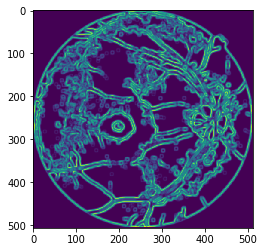

In [222]:
print(uniq.min(), uniq.mean(), uniq.max())
#Image.fromarray(uniq*255).convert('RGB')
#np.exp(-1 * get_neighbour_distance(3))
fig, ax = plt.subplots()
ax.imshow(uniq)

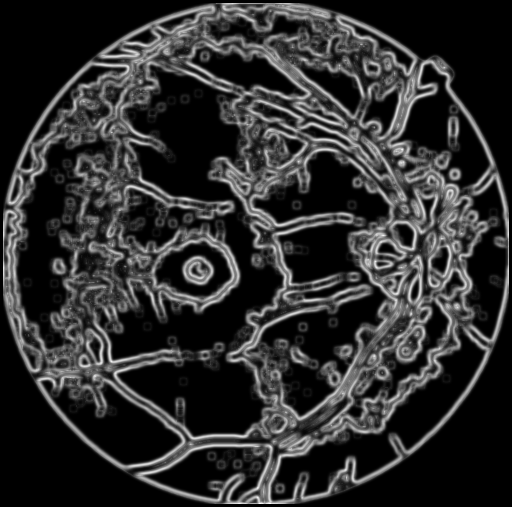

In [223]:
Image.fromarray(uniq*255).convert('RGB')

[ 0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696   0.02717246  0.05910575  0.10687793  0.13533528  0.10687793
  0.05910575  0.02717246  0.04232922  0.10687793  0.24311673  0.36787944
  0.24311673  0.10687793  0.04232922  0.04978707  0.13533528  0.36787944
  1.          0.36787944  0.13533528  0.04978707  0.04232922  0.10687793
  0.24311673  0.36787944  0.24311673  0.10687793  0.04232922  0.02717246
  0.05910575  0.10687793  0.13533528  0.10687793  0.05910575  0.02717246
  0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696 ]


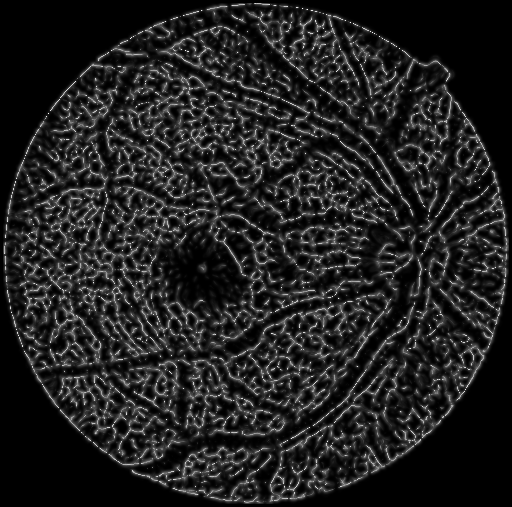

In [227]:
uniq = uniqueness(arr, curvature.clip(0,1))
uniq.min(), uniq.max(), curvature.min(), curvature.max()/255
Image.fromarray(uniq*255).convert('RGB')

In [228]:
sal = 0.4 *  uniqueness(arr, curvature/255.0) + (0.6 *  uniqueness(arr, 1.0-entr))
sal = (sal - sal.min())/sal.max()

[ 0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696   0.02717246  0.05910575  0.10687793  0.13533528  0.10687793
  0.05910575  0.02717246  0.04232922  0.10687793  0.24311673  0.36787944
  0.24311673  0.10687793  0.04232922  0.04978707  0.13533528  0.36787944
  1.          0.36787944  0.13533528  0.04978707  0.04232922  0.10687793
  0.24311673  0.36787944  0.24311673  0.10687793  0.04232922  0.02717246
  0.05910575  0.10687793  0.13533528  0.10687793  0.05910575  0.02717246
  0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696 ]
[ 0.0143696   0.02717246  0.04232922  0.04978707  0.04232922  0.02717246
  0.0143696   0.02717246  0.05910575  0.10687793  0.13533528  0.10687793
  0.05910575  0.02717246  0.04232922  0.10687793  0.24311673  0.36787944
  0.24311673  0.10687793  0.04232922  0.04978707  0.13533528  0.36787944
  1.          0.36787944  0.13533528  0.04978707  0.04232922  0.10687793
  0.24311673  0.36787944  0.24311673 

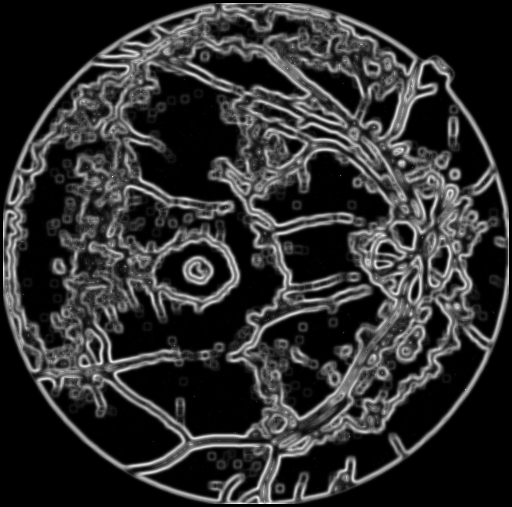

In [229]:
Image.fromarray((sal)*255.0).convert('RGB')

In [120]:
Image.fromarray(Y)

TypeError: expected string or buffer

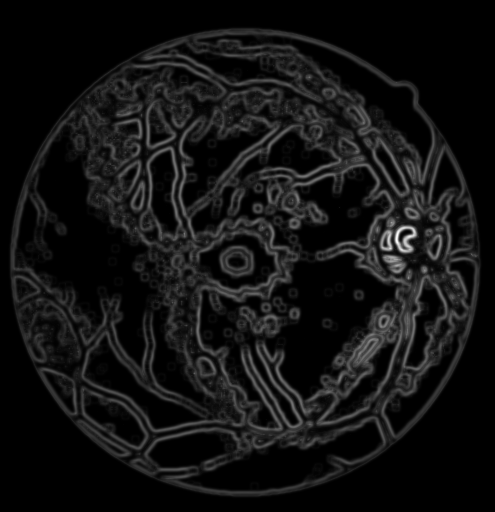

In [122]:
y = arr/arr.max()
e = y*sal
e = (e - e.min())/e.max()
Image.fromarray(e*255.0).convert('RGB')

# Use segmentation masks
Idea: Place a trunc. Gaussian kernel on each node marked as vessel

In [789]:
img = Image.open('../../data/raw/DRIVE/training/1st_manual/21_manual1.gif')
Y = img.convert('YCbCr').split()[0]
arr = np.array(Y)

pad_width = 50
arr = np.pad(arr, pad_width=pad_width, mode='constant')
weights = np.zeros_like(arr, dtype=np.float64)

In [790]:
# Trunc. gaussian kernel
std = 10e4
# First compute distance matrix
kernel_size = 41
kernel = np.zeros((kernel_size,kernel_size))
center = kernel_size//2
for i, j in product(range(kernel_size), range(kernel_size)):
    kernel[i,j] = np.linalg.norm(np.array([i,j]) - center)

# Then Gaussian
kernel = np.exp(-kernel ** 2 / std)
kernel = kernel
#kernel

In [791]:
xs, ys = np.where(arr == 255)
for x, y in zip(xs, ys):
    weights[x-kernel_size//2:x+kernel_size//2+1, y-kernel_size//2:y+kernel_size//2+1] += kernel
# Remove padding
weights = weights[pad_width:-pad_width, pad_width:-pad_width]

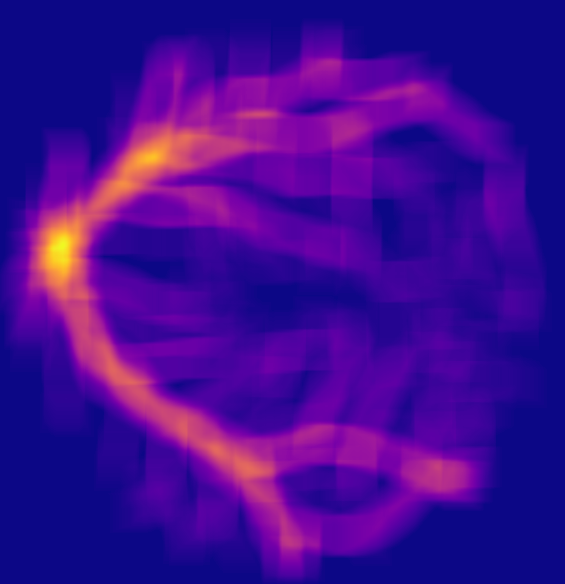

In [792]:
weights = (weights/weights.max())
Image.fromarray(np.uint8(cm.plasma(weights)*255)).convert('RGB')

In [801]:
weights[100:150, 100:150]

array([[ 0.        ,  0.        ,  0.        , ...,  0.23126301,
         0.23129033,  0.23131304],
       [ 0.        ,  0.        ,  0.        , ...,  0.23127622,
         0.23130155,  0.23132226],
       [ 0.        ,  0.        ,  0.        , ...,  0.2312912 ,
         0.23131486,  0.23133389],
       ..., 
       [ 0.00848613,  0.00943102,  0.0103761 , ...,  0.66752659,
         0.67225597,  0.67792682],
       [ 0.00848435,  0.00942906,  0.01037396, ...,  0.68642335,
         0.69021227,  0.6949416 ],
       [ 0.0084824 ,  0.01036599,  0.01225015, ...,  0.70438014,
         0.70722848,  0.71101618]])

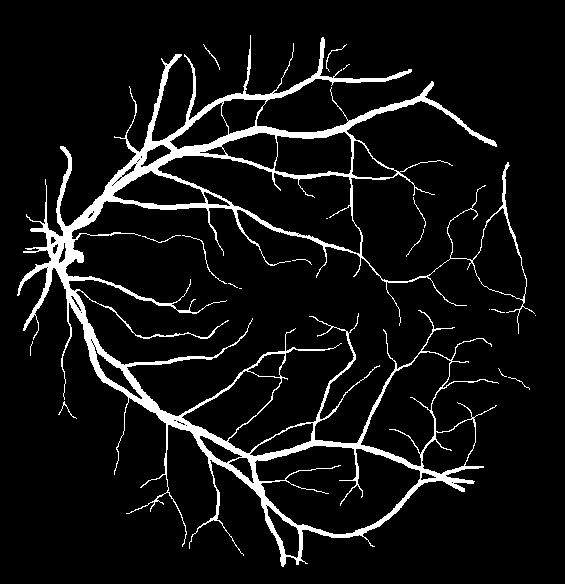

In [802]:
img